In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import geopandas as gpd
import warnings

from tqdm.notebook import trange
from numba import njit
from cartopy.feature import ShapelyFeature
from shapely.geometry import Point
from shapely.vectorized import contains

warnings.filterwarnings("ignore")
projection = ccrs.Orthographic(central_longitude=90, central_latitude=30)
extent = [75.5, 104, 24.5, 40.5]
plt.rcParams['font.family'] = ['Times New Roman', 'SimSun']  # 无衬线字体栈
mpl.rcParams['font.size'] = 11

# 趋势计算函数

In [2]:
@njit
def linear_trend_njit(series):
    # 转换为numpy数组并移除NaN值
    y = np.asarray(series, dtype=np.float64)
    y = y[~np.isnan(y)]
    n = len(y)
    
    # 如果数据点太少，返回NaN
    if n < 2:
        return np.nan
    
    # 创建x轴（时间索引）
    x = np.arange(n, dtype=np.float64)
    
    # 计算均值
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    
    # 计算斜率和截距
    numerator = 0.0
    denominator = 0.0
    
    for i in range(n):
        numerator += (x[i] - x_mean) * (y[i] - y_mean)
        denominator += (x[i] - x_mean) ** 2
    
    # 如果分母为0，返回NaN
    if denominator == 0:
        return np.nan
    
    slope = 10 * numerator / denominator
    
    return slope

@njit
def cal_trend_grid_njit(data_array):
    time_len, lat_len, lon_len = data_array.shape
    trend_array = np.full((lat_len, lon_len), np.nan)
    
    for i in range(lat_len):
        for j in range(lon_len):
            series = data_array[:, i, j]
            if np.any(np.isnan(series)):
                continue
            trend_value = linear_trend_njit(series)
            trend_array[i, j] = trend_value
    return trend_array

# 气象站点气温、降水趋势

In [3]:
meteo_stations_info = pd.read_csv("../data/meteo_stations_data/meteo_stations.txt", sep='\t')
meteo_stations_list = meteo_stations_info['ID'].tolist()

In [4]:
# for m in trange(len(meteo_stations_list)):

#     meteo_station = meteo_stations_list[m]
#     p_data_fp = f"F:/中国气象数据网/datasets/PRE/stations/TEMP_SURF_CLI_CHN_MUL_DAY-PRE-13011-{meteo_station}.xlsx"

#     p_data = pd.read_excel(p_data_fp)
#     p_data = p_data[:-365]
#     p_data['Year'] = p_data['年']
#     p_data['Month'] = p_data['月']
#     p_data['Day'] = p_data['日']
#     p_data = p_data[p_data['Day'] != 32]
#     p_data['Time'] = pd.to_datetime(p_data[['Year', 'Month', 'Day']])
#     p_data = p_data.drop(columns=['年', '月', '日'])
#     p_data = p_data.set_index('Time')

#     p_series = p_data['PRE']
#     p_series = p_series.replace(-999.0, np.nan)
#     p_series_nan = np.where(~np.isnan(p_series))[0]
#     p_series = p_series[p_series.index[p_series_nan[0] : p_series_nan[-1] + 1]]

#     p_series_y = p_series.resample("YS").sum(min_count=250)
#     p_series_y = p_series_y.dropna()
#     p_trend_value = 10 * np.polyfit(np.arange(len(p_series_y)), p_series_y.values, 1)[0]
#     p_trend_percent = p_trend_value / p_series_y.mean() * 100

#     meteo_trend[m, 0] = meteo_station
#     meteo_trend[m, 1] = p_series.index[0].strftime('%Y%m%d')
#     meteo_trend[m, 2] = p_series.index[-1].strftime('%Y%m%d')
#     meteo_trend[m, 3] = p_trend_value
#     meteo_trend[m, 4] = p_trend_percent

#     t_data_fp = f"F:/中国气象数据网/datasets/TEM/stations/SURF_CLI_CHN_MUL_DAY-TEM-12001-{meteo_station}.xlsx"

#     t_data = pd.read_excel(t_data_fp)
#     t_data = t_data[:-365]
#     t_data['Year'] = t_data['年']
#     t_data['Month'] = t_data['月']
#     t_data['Day'] = t_data['日']
#     t_data = t_data[t_data['Day'] != 32]
#     t_data['Time'] = pd.to_datetime(t_data[['Year', 'Month', 'Day']])
#     t_data = t_data.drop(columns=['年', '月', '日', 'TEM_max', 'TEM_min'])
#     t_data = t_data.set_index('Time')

#     t_series = t_data['TEM_ave']
#     t_series = t_series.replace(-999.0, np.nan)
#     t_series_nan = np.where(~np.isnan(t_series))[0]
#     t_series = t_series[t_series.index[t_series_nan[0] : t_series_nan[-1] + 1]]

#     t_series_y_mean = t_series.resample("YS").mean()
#     t_series_y_count = t_series.resample("YS").count()
#     t_series_y = t_series_y_mean.where(t_series_y_count >= 250)
#     t_series_y = t_series_y.dropna()
#     t_trend_value = 10 * np.polyfit(np.arange(len(t_series_y)), t_series_y.values, 1)[0]

#     meteo_trend[m, 5] = t_series.index[0].strftime('%Y%m%d')
#     meteo_trend[m, 6] = t_series.index[-1].strftime('%Y%m%d')
#     meteo_trend[m, 7] = t_trend_value

#     new_meteo_data = pd.DataFrame(p_data)
#     new_meteo_data = new_meteo_data.drop(columns=['Year', 'Month', 'Day'])
#     new_meteo_data['TEM'] = t_data['TEM_ave']
#     new_meteo_data = new_meteo_data.replace(-999.0, np.nan)
#     new_meteo_data.to_csv(f"../data/meteo_stations_data/meteo_{meteo_station}.txt", index_label='Time', sep='\t', float_format="%.2f")

In [4]:
meteo_trend = np.full((len(meteo_stations_list), 10), np.nan)

for m in trange(len(meteo_stations_list)):

    meteo_station = meteo_stations_list[m]
    data_fp = f"../data/meteo_stations_data/meteo_{meteo_station}.txt"
    data = pd.read_csv(data_fp, sep='\t', parse_dates=['Time'], index_col='Time')

    p_series = data['PRE']
    p_series_nan = np.where(~np.isnan(p_series))[0]
    p_series = p_series[p_series.index[p_series_nan[0] : p_series_nan[-1] + 1]]

    p_series_y = p_series.resample("YS").sum(min_count=250)
    p_series_y = p_series_y.dropna()
    p_trend_value = linear_trend_njit(p_series_y.values)
    p_trend_percent = p_trend_value / p_series_y.mean() * 100

    meteo_trend[m, 0] = meteo_station
    meteo_trend[m, 1] = p_series.index[0].strftime('%Y%m%d')
    meteo_trend[m, 2] = p_series.index[-1].strftime('%Y%m%d')
    meteo_trend[m, 3] = p_series_y.mean()
    meteo_trend[m, 4] = p_trend_value
    meteo_trend[m, 5] = p_trend_percent

    t_series = data['TEM']
    t_series_nan = np.where(~np.isnan(t_series))[0]
    t_series = t_series[t_series.index[t_series_nan[0] : t_series_nan[-1] + 1]]

    t_series_y_mean = t_series.resample("YS").mean()
    t_series_y_count = t_series.resample("YS").count()
    t_series_y = t_series_y_mean.where(t_series_y_count >= 250)
    t_series_y = t_series_y.dropna()
    t_trend_value = linear_trend_njit(t_series_y.values)

    meteo_trend[m, 6] = t_series.index[0].strftime('%Y%m%d')
    meteo_trend[m, 7] = t_series.index[-1].strftime('%Y%m%d')
    meteo_trend[m, 8] = t_series_y.mean()
    meteo_trend[m, 9] = t_trend_value

  0%|          | 0/157 [00:00<?, ?it/s]

In [5]:
meteo_trend_df = pd.DataFrame(meteo_trend, columns=['ID', 'pre_st', 'pre_ed', 'pre_mean', 'pre_t_v', 'pre_t_p', 'tem_st', 'tem_ed', 'tem_mean', 'tem_t_v'])
int_columns = ['ID', 'pre_st', 'pre_ed', 'tem_st', 'tem_ed']
for col in int_columns:
    meteo_trend_df[col] = meteo_trend_df[col].astype(int)
meteo_trend_df.to_csv("../results/meteo_stations_trend/meteo_climatic_trend.txt", index=False, sep='\t', float_format="%.2f")

# 格点气象趋势

In [14]:
time_series_cn05 = pd.date_range(start='1961-01-01', end='2018-12-31', freq='MS')
time_series_cru  = pd.date_range(start='1901-01-01', end='2024-12-31', freq='MS')

study_st = pd.Timestamp('1961-01-01')
study_ed = pd.Timestamp('2021-12-31')

loc_cn05 = (time_series_cn05 >= study_st) & (time_series_cn05 <= study_ed)
loc_cru  = (time_series_cru  >= study_st) & (time_series_cru  <= study_ed)

qtp_shp_fp = "../data/shape/QTP.shp"
qtp_gdf = gpd.read_file(qtp_shp_fp)

study_cat_fp = "../data/shape/study_catchments.shp"
study_cat_gdf = gpd.read_file(study_cat_fp)

In [15]:
p_cn05_fp   = "../../Data/CN05/CN05_Pre_1961_2018_month_025.nc"
p_cn05_ds   = xr.open_dataset(p_cn05_fp)
p_cn05_lon  = p_cn05_ds['lon']
p_cn05_lat  = p_cn05_ds['lat']
p_cn05_data = p_cn05_ds['pre'] * 30.4
p_cn05_ds.close()

t_cn05_fp   = "../../Data/CN05/CN05_Tm_1961_2018_month_025.nc"
t_cn05_ds   = xr.open_dataset(t_cn05_fp)
t_cn05_lon  = t_cn05_ds['lon']
t_cn05_lat  = t_cn05_ds['lat']
t_cn05_data = t_cn05_ds['tm']
t_cn05_ds.close()

p_cru_fp    = "../../Data/CRU_TS/pre_1901_2024.nc"
p_cru_ds    = xr.open_dataset(p_cru_fp)
p_cru_lon   = p_cru_ds['lon']
p_cru_lat   = p_cru_ds['lat']
p_cru_data  = p_cru_ds['pre']
p_cru_ds.close()

t_cru_fp    = "../../Data/CRU_TS/tmp_1901_2024.nc"
t_cru_ds    = xr.open_dataset(t_cru_fp)
t_cru_lon   = t_cru_ds['lon']
t_cru_lat   = t_cru_ds['lat']
t_cru_data  = t_cru_ds['tmp']
t_cru_ds.close()

def get_mask(lon, lat, shape_gdf):
    lon_grid, lat_grid = np.meshgrid(lon, lat)
    points = np.vstack((lon_grid.ravel(), lat_grid.ravel())).T
    mask = contains(shape_gdf.unary_union, points[:, 0], points[:, 1])
    mask = np.float32(mask)
    mask[mask == 0] = np.nan
    return mask.reshape(lon_grid.shape)

p_cn05_mask = get_mask(p_cn05_lon.values, p_cn05_lat.values, qtp_gdf)
t_cn05_mask = get_mask(t_cn05_lon.values, t_cn05_lat.values, qtp_gdf)
p_cru_mask  = get_mask(p_cru_lon.values, p_cru_lat.values, qtp_gdf)
t_cru_mask  = get_mask(t_cru_lon.values, t_cru_lat.values, qtp_gdf)

In [16]:
p_cn05_study = p_cn05_data[loc_cn05, :, :].values
t_cn05_study = t_cn05_data[loc_cn05, :, :].values
p_cru_study  = p_cru_data[loc_cru, :, :].values
t_cru_study  = t_cru_data[loc_cru, :, :].values

p_cn05_study = np.nanmean(p_cn05_study.reshape(int(p_cn05_study.shape[0] / 12), 12, p_cn05_study.shape[1], p_cn05_study.shape[2]), axis=1) * 12
t_cn05_study = np.nanmean(t_cn05_study.reshape(int(t_cn05_study.shape[0] / 12), 12, t_cn05_study.shape[1], t_cn05_study.shape[2]), axis=1)
p_cru_study  = np.nanmean(p_cru_study.reshape(int(p_cru_study.shape[0] / 12), 12, p_cru_study.shape[1], p_cru_study.shape[2]), axis=1) * 12
t_cru_study  = np.nanmean(t_cru_study.reshape(int(t_cru_study.shape[0] / 12), 12, t_cru_study.shape[1], t_cru_study.shape[2]), axis=1)

In [27]:
p_series = np.nanmean(p_cn05_study, axis=(1,2))
linear_trend_njit(p_series)

6.361717879598005

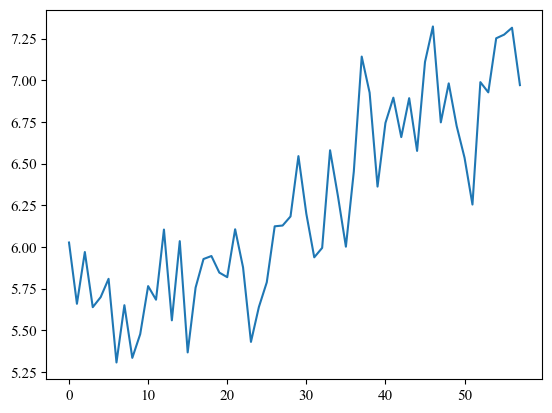

In [23]:
plt.plot(t_series)

In [12]:
p_t_v_cn05 = cal_trend_grid_njit(p_cn05_study)
t_t_v_cn05 = cal_trend_grid_njit(t_cn05_study)
p_t_v_cru  = cal_trend_grid_njit(p_cru_study)
t_t_v_cru  = cal_trend_grid_njit(t_cru_study)
p_t_per_cn05 = p_t_v_cn05 / np.nanmean(p_cn05_study, axis=0) * 100
p_t_per_cru  = p_t_v_cru  / np.nanmean(p_cru_study, axis=0)  * 100

In [13]:
p_t_v_cn05 = p_t_v_cn05 * p_cn05_mask
t_t_v_cn05 = t_t_v_cn05 * t_cn05_mask
p_t_v_cru  = p_t_v_cru  * p_cru_mask
t_t_v_cru  = t_t_v_cru  * t_cru_mask
p_t_per_cn05 = p_t_per_cn05 * p_cn05_mask
p_t_per_cru  = p_t_per_cru  * p_cru_mask

# 绘制趋势图

In [15]:
def plot_assist_element(ax, qtp_bound=True, study_cat=False):
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)
    gl.ylocator = mpl.ticker.FixedLocator([25, 30, 35, 40])
    gl.top_labels = False
    gl.right_labels = False
    if qtp_bound:
        feat = ShapelyFeature(qtp_gdf.geometry, ccrs.PlateCarree(), edgecolor='black', facecolor='none', linewidth=1.2, zorder=5)
        ax.add_feature(feat)
    if study_cat:
        feat = ShapelyFeature(study_cat_gdf.geometry, ccrs.PlateCarree(), edgecolor="#616161", facecolor='none', linewidth=1.0, zorder=5)
        ax.add_feature(feat)

def plot_class_scatter_1d(ax, x, y, data, th1, th2, color='red', marker='^', label=None, title=None):
    s = np.full(len(data), np.nan)
    for i in range(len(data)):
        if data[i] >= th2:
            s[i] = 100
        elif data[i] >= th1:
            s[i] = 50
        else:
            s[i] = 20
    ax.scatter(x, y, s=s, c=color, marker=marker, linewidths=0, zorder=5, transform=ccrs.PlateCarree())
    if label is not None:
        # 添加图例
        legend_elements = [
            plt.scatter([], [], marker=marker, color=color, label=f'> {th2}',       s=100),
            plt.scatter([], [], marker=marker, color=color, label=f'{th1} - {th2}', s=50),
            plt.scatter([], [], marker=marker, color=color, label=f'< {th1}',       s=20),
        ]
        ax.legend(handles=legend_elements, loc='lower left', scatterpoints=1, handletextpad=0.5, title=label, fontsize=mpl.rcParams['font.size'])
    if title is not None:
        ax.set_title(title, fontsize=mpl.rcParams['font.size'])

def plot_class_scatter_2d(ax, x, y, data, th1, th2, pos_color='red', neg_color='blue', label=None, title=None):
    pos_data = data[data >= 0]
    pos_x = x[data >= 0]
    pos_y = y[data >= 0]
    neg_data = data[data < 0]
    neg_x = x[data < 0]
    neg_y = y[data < 0]
    s = np.full(len(data), np.nan)
    for i in range(len(data)):
        if np.abs(data[i]) >= th2:
            s[i] = 100
        elif np.abs(data[i]) >= th1:
            s[i] = 50
        else:
            s[i] = 20
    ax.scatter(pos_x, pos_y, s=s[data >= 0], c=pos_color, marker='^', linewidths=0, zorder=5, transform=ccrs.PlateCarree())
    ax.scatter(neg_x, neg_y, s=s[data < 0], c=neg_color, marker='v', linewidths=0, zorder=5, transform=ccrs.PlateCarree())
    if label is not None:
        # 添加图例
        legend_elements = [
            plt.scatter([], [], marker='^', color=pos_color, label=f'> {th1}',           s=100),
            plt.scatter([], [], marker='^', color=pos_color, label=f'{th1} - {th2}',     s=50),
            plt.scatter([], [], marker='^', color=pos_color, label=f'0 - {th1}',         s=20),
            plt.scatter([], [], marker='v', color=neg_color, label=f'{th1} - 0',         s=20),
            plt.scatter([], [], marker='v', color=neg_color, label=f'{-th2} - {-th1}',   s=50),
            plt.scatter([], [], marker='v', color=neg_color, label=f'< {-th2}',          s=100)
        ]
        ax.legend(handles=legend_elements, loc='lower left', scatterpoints=1, handletextpad=0.5, title=label, fontsize=mpl.rcParams['font.size'])
    if title is not None:
        ax.set_title(title, fontsize=mpl.rcParams['font.size'])
        
def plot_stretch_scatter(ax, x, y, data, cmap="Blues", vmin=None, vmax=None, label=None, extend=None, ticks=None, title=None):
    arr = np.asarray(data, dtype=float)
    # determine vmin/vmax from data if not provided
    if vmin is None:
        try:
            vmin = np.nanmin(arr)
        except:
            vmin = 0.0
    if vmax is None:
        try:
            vmax = np.nanmax(arr)
        except:
            vmax = 1.0
    # guard against degenerate range
    if np.isnan(vmin) or np.isnan(vmax) or vmin == vmax:
        vmin, vmax = vmin - 0.5 if not np.isnan(vmin) else 0.0, vmax + 0.5 if not np.isnan(vmax) else 1.0

    # create colormap
    cmap_obj = mpl.cm.get_cmap(cmap)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    # plot
    sc = ax.scatter(x, y, c=arr, cmap=cmap_obj, norm=norm, s=50, marker='o', linewidths=0, zorder=5, transform=ccrs.PlateCarree())

    # colorbar placement (horizontal, below/inside axes)
    pos = ax.get_position()
    cax = ax.figure.add_axes([pos.x0 + 0.02 * pos.width, pos.y0 + 0.101 * pos.height, pos.width * 0.35, 0.014])
    cb = plt.colorbar(sc, cax=cax, orientation='horizontal', extend=extend)
    if ticks is not None:
        cb.set_ticks(ticks)
    else:
        cb.ax.tick_params(labelsize=mpl.rcParams['font.size'])
    cb.set_label(label, fontsize=mpl.rcParams['font.size'], loc='center', labelpad=-39)
    if title is not None:
        ax.set_title(title, fontsize=mpl.rcParams['font.size'])

def plot_stretch_map(ax, lon, lat, data, vmin=None, vmax=None, cmap='Blues', bar_extend=None, ticks=None, label=None, title=None):
    # 绘制栅格数据（使用 PlateCarree 作为数据坐标系）
    im = ax.pcolormesh(lon, lat, data, transform=ccrs.PlateCarree(), cmap=cmap, shading='auto', vmin=vmin, vmax=vmax)
    # 标题与色标
    pos = ax.get_position()
    cax = ax.figure.add_axes([pos.x0 + 0.02 * pos.width, pos.y0 + 0.101 * pos.height, pos.width * 0.35, 0.014])
    cb = plt.colorbar(im, cax=cax, orientation='horizontal', extend=bar_extend)
    if ticks is not None:
        cb.set_ticks(ticks)
    else:
        cb.ax.tick_params(labelsize=mpl.rcParams['font.size'])
    cb.set_label(label, fontsize=mpl.rcParams['font.size'], loc='center', labelpad=-39)
    if title is not None:
        ax.set_title(title, fontsize=mpl.rcParams['font.size'])

def plot_class_map(ax, lon, lat, data, cmap="Blues", vmin=None, vmax=None, class_num=3, bar_extend=None, ticks=None, label=None, title=None):
    arr = np.asarray(data, dtype=float)
    # determine vmin/vmax from data if not provided
    if vmin is None:
        try:
            vmin = np.nanmin(arr)
        except:
            vmin = 0.0
    if vmax is None:
        try:
            vmax = np.nanmax(arr)
        except:
            vmax = 1.0
    # guard against degenerate range
    if np.isnan(vmin) or np.isnan(vmax) or vmin == vmax:
        vmin, vmax = vmin - 0.5 if not np.isnan(vmin) else 0.0, vmax + 0.5 if not np.isnan(vmax) else 1.0

    # create class boundaries and colormap
    if bar_extend == 'both':
        boundaries = np.linspace(vmin, vmax, class_num + 3)
        class_num += 2
    elif bar_extend in ['min', 'max']:
        boundaries = np.linspace(vmin, vmax, class_num + 2)
        class_num += 1
    else:
        boundaries = np.linspace(vmin, vmax, class_num + 1)
    cmap_obj = mpl.cm.get_cmap(cmap, class_num)
    norm = mpl.colors.BoundaryNorm(boundaries, ncolors=cmap_obj.N, clip=False)

    # plot
    im = ax.pcolormesh(lon, lat, arr, transform=ccrs.PlateCarree(), cmap=cmap_obj, norm=norm, shading='auto')

    # colorbar placement (horizontal, below/inside axes similar to stretch map)
    pos = ax.get_position()
    cax = ax.figure.add_axes([pos.x0 + 0.02 * pos.width, pos.y0 + 0.101 * pos.height, pos.width * 0.35, 0.014])
    # ticks: if provided use them, otherwise use centers of classes
    if ticks is None:
        tick_vals = (boundaries[:-1] + boundaries[1:]) / 2.0
    else:
        tick_vals = ticks
    cb = plt.colorbar(im, cax=cax, orientation='horizontal', extend=bar_extend, boundaries=boundaries, ticks=tick_vals)
    # 关闭次刻度（minor ticks）
    try:
        cb.ax.minorticks_off()
    except Exception:
        # 兼容性：显式移除次刻度定位器并隐藏次刻度刻度线
        cb.ax.xaxis.set_minor_locator(mpl.ticker.NullLocator())
        cb.ax.tick_params(which='minor', length=0)
    # set readable tick labels as interval strings when using default centers
    if ticks is None:
        labels = [f"{boundaries[i]:.2f}–{boundaries[i+1]:.2f}" for i in range(len(boundaries)-1)]
        cb.set_ticklabels(labels)
    else:
        cb.ax.tick_params(labelsize=mpl.rcParams['font.size'])
    cb.set_label(label, fontsize=mpl.rcParams['font.size'], loc='center', labelpad=-39)
    if title is not None:
        ax.set_title(title, fontsize=mpl.rcParams['font.size'])

## 气温降水站点变化趋势

In [18]:
fig, ax = plt.subplots(2, 3, figsize=(18, 8), subplot_kw={'projection': projection})
ax[0, 2].remove()

lon = meteo_stations_info['Longitude'].values
lat = meteo_stations_info['Latitude'].values

# 辅助要素
plot_assist_element(ax[0, 0], qtp_bound=True, study_cat=True)
plot_assist_element(ax[0, 1], qtp_bound=True, study_cat=True)
plot_assist_element(ax[1, 0], qtp_bound=True, study_cat=True)
plot_assist_element(ax[1, 1], qtp_bound=True, study_cat=True)
plot_assist_element(ax[1, 2], qtp_bound=True, study_cat=True)

plot_stretch_scatter(ax[0, 0], lon, lat, meteo_trend[:, 8], cmap="RdBu_r", vmin=-15, vmax=15, label='平均气温 (℃)', extend='both', ticks=[-15, 0, 15], title='(a) 多年平均气温')
plot_stretch_scatter(ax[0, 1], lon, lat, meteo_trend[:, 3], cmap="Blues", vmin=100, vmax=900, label='平均降水 (mm)', extend='max', ticks=[100, 500, 900], title='(b) 多变平均降水')
# plot_stretch_scatter(ax[1, 0], lon, lat, meteo_trend[:, 9], cmap="OrRd", vmin=0, vmax=0.5, label='气温趋势 (℃/10年)', extend='max', ticks=[0, 0.25, 0.5], title='(c) 气温变化趋势')
plot_class_scatter_1d(ax[1, 0], lon, lat, meteo_trend[:, 9], th1=0.3, th2=0.6, color='#E44D35', marker='^', label='气温趋势\n(℃/10年)', title='(c) 气温变化趋势')
plot_class_scatter_2d(ax[1, 1], lon, lat, meteo_trend[:, 4], th1=10, th2=20, pos_color='#3B8BC2', neg_color='#E44D35', label='降水趋势\n(mm/10年)', title='(d) 降水变化趋势')
plot_class_scatter_2d(ax[1, 2], lon, lat, meteo_trend[:, 5], th1=3, th2=5, pos_color='#3B8BC2', neg_color='#E44D35', label='降水趋势\n(%/10年)', title='(e) 降水变化趋势百分比')

plt.savefig("../figures/climatic_trend/climatic_trend_station.jpg", dpi=600, bbox_inches='tight')
plt.close()

## 气温降水格点变化趋势 - CN05 - 1961-2018

In [179]:
fig, ax = plt.subplots(2, 3, figsize=(18, 8), subplot_kw={'projection': projection})
ax[0, 2].remove()

plot_assist_element(ax[0, 0], qtp_bound=True, study_cat=False)
plot_assist_element(ax[0, 1], qtp_bound=True, study_cat=False)
plot_assist_element(ax[1, 0], qtp_bound=True, study_cat=False)
plot_assist_element(ax[1, 1], qtp_bound=True, study_cat=False)
plot_assist_element(ax[1, 2], qtp_bound=True, study_cat=False)

plot_stretch_map(ax[0, 0], t_cn05_lon, t_cn05_lat, np.nanmean(t_cn05_study, axis=0) * t_cn05_mask, vmin=-15, vmax=15, cmap='RdBu_r', ticks=[-15, 0, 15], label='平均气温 (℃)', title='(a) 多年平均气温', bar_extend='both')
plot_stretch_map(ax[0, 1], p_cn05_lon, p_cn05_lat, np.nanmean(p_cn05_study, axis=0) * p_cn05_mask, vmin=100, vmax=900, cmap='Blues', ticks=[100, 500, 900], label='平均降水 (mm)', title='(b) 多年平均降水', bar_extend='max')
plot_stretch_map(ax[1, 0], t_cn05_lon, t_cn05_lat, t_t_v_cn05, vmin=0, vmax=0.5, cmap='OrRd', ticks=[0, 0.25, 0.5], label='气温趋势 (℃/10年)', title='(c) 气温变化趋势', bar_extend='max')
plot_stretch_map(ax[1, 1], p_cn05_lon, p_cn05_lat, p_t_v_cn05, vmin=0, vmax=20, label='降水趋势(mm/10年)', title='(d) 降水变化趋势', bar_extend='max', ticks=[0, 10, 20])
plot_stretch_map(ax[1, 2], p_cn05_lon, p_cn05_lat, p_t_per_cn05, vmin=0, vmax=10, label='降水趋势(%/10年)', title='(e) 降水变化趋势百分比', bar_extend='max', ticks=[0, 5, 10])

plt.savefig("../figures/climatic_trend/climatic_trend_cn05.jpg", dpi=600, bbox_inches='tight')
plt.close()

## 气温降水格点变化趋势 - CRU - 1961-2024

In [180]:
fig, ax = plt.subplots(2, 3, figsize=(18, 8), subplot_kw={'projection': projection})
ax[0, 2].remove()

plot_assist_element(ax[0, 0], qtp_bound=True, study_cat=False)
plot_assist_element(ax[0, 1], qtp_bound=True, study_cat=False)
plot_assist_element(ax[1, 0], qtp_bound=True, study_cat=False)
plot_assist_element(ax[1, 1], qtp_bound=True, study_cat=False)
plot_assist_element(ax[1, 2], qtp_bound=True, study_cat=False)

plot_stretch_map(ax[0, 0], t_cru_lon, t_cru_lat, np.nanmean(t_cru_study, axis=0) * t_cru_mask, vmin=-15, vmax=15, cmap='RdBu_r', ticks=[-15, 0, 15], label='平均气温 (℃)', title='(a) 多年平均气温', bar_extend='both')
plot_stretch_map(ax[0, 1], p_cru_lon, p_cru_lat, np.nanmean(p_cru_study, axis=0) * p_cru_mask, vmin=100, vmax=900, cmap='Blues', ticks=[100, 500, 900], label='平均降水 (mm)', title='(b) 多年平均降水', bar_extend='max')
plot_stretch_map(ax[1, 0], t_cru_lon, t_cru_lat, t_t_v_cru, vmin=0, vmax=0.5, cmap='OrRd', ticks=[0, 0.25, 0.5], label='气温趋势 (℃/10年)', title='(c) 气温变化趋势', bar_extend='max')
plot_stretch_map(ax[1, 1], p_cru_lon, p_cru_lat, p_t_v_cru, vmin=0, vmax=20, label='降水趋势(mm/10年)', title='(d) 降水变化趋势', bar_extend='max', ticks=[0, 10, 20])
plot_stretch_map(ax[1, 2], p_cru_lon, p_cru_lat, p_t_per_cru, vmin=0, vmax=10, label='降水趋势(%/10年)', title='(e) 降水变化趋势百分比', bar_extend='max', ticks=[0, 5, 10])

plt.savefig("../figures/climatic_trend/climatic_trend_cru.jpg", dpi=600, bbox_inches='tight')
plt.close()